In [1]:
import pandas as pd
import os
import datetime
from tqdm.notebook import tqdm

from scipy import stats
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

data_path = os.path.join('datasets', 'open-data')

## Read sensor data

In [2]:
sensor_df = pd.read_csv(os.path.join('datasets', 'sensor','raw_sensor_data.csv'), index_col=0, parse_dates=True)
sensor_df['total'] = sensor_df['20 30 40 50 65 80 90 100 110 120 130 140 150 160 236'.split()].sum(axis=1)
sensor_df = sensor_df[sensor_df['total']>0]
sensor_df.head()

lane  veh_type  aux   20   30   40   50   65   80   90  \
date                                                                          
2021-01-01 10:45:00     1         1    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-01 10:45:00     1         2    0  0.0  0.0  0.0  0.0  0.0  0.0  2.0   
2021-01-01 10:45:00     2         1    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-01 10:45:00     3         1    0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2021-01-01 10:45:00     3         2    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                     100  110  120  130  140  150  160  236 roadway  total  
date                                                                        
2021-01-01 10:45:00  2.0  3.0  4.0  2.0  0.0  1.0  0.0  0.0      r1   12.0  
2021-01-01 10:45:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      r1    2.0  
2021-01-01 10:45:00  0.0  0.0  2.0  0.0  1.0  0.0  0.0  0.0      r1    3.0  
2021-01-01 10:45:00  0.0  1.0  7.0  3.0  2.0  1.0  0.0  0.0      r2   15.0  
2021-01-01 10:45:00  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      r2    1.0

In [3]:
sensor_by_roadway= sensor_df[sensor_df['total']>0].groupby(['date','roadway'])['total'].sum().to_frame()
sensor_by_roadway=sensor_by_roadway.reset_index(level=1)
sensor_by_roadway.head()

roadway  total
date                              
2021-01-01 10:45:00      r1   17.0
2021-01-01 10:45:00      r2   16.0
2021-01-01 11:00:00      r1   36.0
2021-01-01 11:00:00      r2   61.0
2021-01-01 11:15:00      r1   41.0

In [4]:
r1_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r1'].drop('roadway', axis=1)
r1_series.head()

total
date                      
2021-01-01 10:45:00   17.0
2021-01-01 11:00:00   36.0
2021-01-01 11:15:00   41.0
2021-01-01 11:30:00   58.0
2021-01-01 11:45:00   49.0

In [5]:
r2_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r2'].drop('roadway', axis=1)
r2_series.head()

total
date                      
2021-01-01 10:45:00   16.0
2021-01-01 11:00:00   61.0
2021-01-01 11:15:00   63.0
2021-01-01 11:30:00   58.0
2021-01-01 11:45:00   57.0

In [6]:
total_sensor= sensor_df['total'].groupby('date').sum('total').to_frame()
total_sensor.head()

total
date                      
2021-01-01 10:45:00   33.0
2021-01-01 11:00:00   97.0
2021-01-01 11:15:00  104.0
2021-01-01 11:30:00  116.0
2021-01-01 11:45:00  106.0

## Read city flows

In [7]:
burgos_mas = '0905901_AD 0905903 0905905 0905906 0905909 0905907 0905908'.split()
palencia_mas= '3412001 3412003 3412004 3412005 3412006 3412007'.split()
valladolid_mas= '4718601 4718602 4718603 4718604 4718605 4718606 4718607 4718608 4718609 4718610 4718611'.split()

end_date = datetime.datetime.strptime('2021-02-01', '%Y-%m-%d')
start_date = datetime.datetime.strptime('2021-01-01', '%Y-%m-%d')

In [8]:
def generate_days_fn(init_date, final_date):
    
    delta = final_date - init_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = init_date + datetime.timedelta(days=i)
        target_days.append(day)
    
    return target_days

def read_INE_trips_date_fn(date_, trips_type='all'):
    date_str= date_.strftime('%Y%m%d')
    df_date= pd.read_csv(os.path.join(data_path, f'{date_str}_maestra_1_mitma_distrito.txt'), 
                             sep='|',dtype={'origen':str, 'destino':str,'fecha':str, 'periodo':str})
    
    if trips_type=='inter':
        df_date= df_date[df_date['origen']!=df_date['destino']] #only keep trips between areas
    elif trips_type=='intra':
        df_date= df_date[df_date['origen']==df_date['destino']] #only keep trips within the areas
    
    #convert period column to a two-digit string
    df_date['periodo'] = df_date['periodo'].apply(lambda x: x.zfill(2))
    df_date= df_date.fillna(0) # set nan as 0
    return df_date

def generate_hourly_time_series_fn(city_mas, from_date, to_date, flow_type='outgoing', trips_type='all'):
     
    target_col = 'origen'
    mirror_col = 'destino'
    if flow_type == 'incoming':
        target_col = 'destino'
        mirror_col = 'origen'
        
    time_series = []
    target_days = generate_days_fn(from_date, to_date)
    for date in tqdm(target_days):
        df = read_INE_trips_date_fn(date, trips_type)
        df= df.drop(['edad', 'viajes_km','residencia'], axis=1)
        df = df[df[target_col].isin(city_mas)]
        df = df[~df[mirror_col].isin(city_mas)]
        
        group_by_df= df.groupby(['fecha',target_col,'periodo'])['viajes'].sum()
        group_by_df= group_by_df.reset_index()
        group_by_df['fecha_periodo'] = group_by_df['fecha']+'_'+ group_by_df['periodo'].astype(str)
        group_by_df= group_by_df.drop('fecha periodo'.split(), axis=1)
        total_trips_final = group_by_df.pivot_table(values='viajes',index='fecha_periodo',columns=target_col)
        time_series.append(total_trips_final)
    ts_df= pd.concat(time_series, axis=0)
    ts_df.index= ts_df.index.map(lambda x: datetime.datetime.strptime(x, "%Y%m%d_%H"))
    ts_df = ts_df.fillna(0.0)
    #we aggregate all the mas
    ts_df = ts_df.sum(axis=1).to_frame()
    ts_df.columns =  ['n_trips']
    
    #Interpolation to set a 15 minutes frequency
    ts_df= ts_df.resample('15min')
    ts_df = ts_df.interpolate(method='linear')
    
    return ts_df    

def generate_hourly_pairwise_time_series_fn(orig_city_ma_lst, dest_city_ma_lst, from_date, to_date, trips_type='all'):
             
    time_series = []
    target_days = generate_days_fn(from_date, to_date)
    for date in tqdm(target_days):
        df = read_INE_trips_date_fn(date, trips_type)
        df= df.drop(['edad', 'viajes_km','residencia'], axis=1)
        df = df[df['origen'].isin(orig_city_ma_lst)]
        df = df[df['destino'].isin(dest_city_ma_lst)]
        
        group_by_df= df.groupby(['fecha','origen','periodo'])['viajes'].sum()
        group_by_df= group_by_df.reset_index()
        group_by_df['fecha_periodo'] = group_by_df['fecha']+'_'+ group_by_df['periodo'].astype(str)
        group_by_df= group_by_df.drop('fecha periodo'.split(), axis=1)
        total_trips_final = group_by_df.pivot_table(values='viajes',index='fecha_periodo',columns='origen')
        time_series.append(total_trips_final)
    ts_df= pd.concat(time_series, axis=0)
    ts_df.index= ts_df.index.map(lambda x: datetime.datetime.strptime(x, "%Y%m%d_%H"))
    ts_df = ts_df.fillna(0.0)
    #we aggregate all the mas
    ts_df = ts_df.sum(axis=1).to_frame()
    ts_df.columns =  ['n_trips']
    
    #Interpolation to set a 15 minutes frequency
    ts_df= ts_df.resample('15min')
    ts_df = ts_df.interpolate(method='linear')

    return ts_df 

## Generation of the individual flows per city

In [9]:
bur_out_ts= generate_hourly_time_series_fn(burgos_mas, start_date, end_date, flow_type='outgoing')
bur_in_ts= generate_hourly_time_series_fn(burgos_mas, start_date, end_date, flow_type='incoming')

pal_out_ts= generate_hourly_time_series_fn(palencia_mas, start_date, end_date, flow_type='outgoing')
pal_in_ts= generate_hourly_time_series_fn(palencia_mas, start_date, end_date, flow_type='incoming')

val_out_ts= generate_hourly_time_series_fn(valladolid_mas, start_date, end_date, flow_type='outgoing')
val_in_ts= generate_hourly_time_series_fn(valladolid_mas, start_date, end_date, flow_type='incoming')

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
bur_out_ts.head()

n_trips
fecha_periodo                 
2021-01-01 00:00:00  1947.1240
2021-01-01 00:15:00  1865.3055
2021-01-01 00:30:00  1783.4870
2021-01-01 00:45:00  1701.6685
2021-01-01 01:00:00  1619.8500

In [11]:
bur_in_ts.head()

n_trips
fecha_periodo                  
2021-01-01 00:00:00  1481.36700
2021-01-01 00:15:00  1435.42225
2021-01-01 00:30:00  1389.47750
2021-01-01 00:45:00  1343.53275
2021-01-01 01:00:00  1297.58800

In [12]:
bur_in_ts.to_csv(os.path.join('datasets', 'timeseries', 'bur_in.csv'))
bur_out_ts.to_csv(os.path.join('datasets', 'timeseries', 'bur_out.csv'))

pal_in_ts.to_csv(os.path.join('datasets', 'timeseries', 'pal_in.csv'))
pal_out_ts.to_csv(os.path.join('datasets', 'timeseries', 'pal_out.csv'))

val_in_ts.to_csv(os.path.join('datasets', 'timeseries', 'val_in.csv'))
val_out_ts.to_csv(os.path.join('datasets', 'timeseries', 'val_out.csv'))

## Generation of the pairwise city flows

In [13]:
bur_pal_ts= generate_hourly_pairwise_time_series_fn(burgos_mas, palencia_mas, start_date, end_date)
pal_bur_ts= generate_hourly_pairwise_time_series_fn(palencia_mas, burgos_mas, start_date, end_date)

bur_val_ts= generate_hourly_pairwise_time_series_fn(burgos_mas, valladolid_mas, start_date, end_date)
val_bur_ts= generate_hourly_pairwise_time_series_fn(valladolid_mas, burgos_mas, start_date, end_date)

val_pal_ts= generate_hourly_pairwise_time_series_fn(valladolid_mas, palencia_mas, start_date, end_date)
pal_val_ts= generate_hourly_pairwise_time_series_fn(palencia_mas, valladolid_mas, start_date, end_date)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [14]:
bur_pal_ts.head()

n_trips
fecha_periodo               
2021-01-01 08:00:00    8.033
2021-01-01 08:15:00    8.419
2021-01-01 08:30:00    8.805
2021-01-01 08:45:00    9.191
2021-01-01 09:00:00    9.577

In [15]:
pal_bur_ts.head()

n_trips
fecha_periodo                
2021-01-01 06:00:00  6.316000
2021-01-01 06:15:00  6.444375
2021-01-01 06:30:00  6.572750
2021-01-01 06:45:00  6.701125
2021-01-01 07:00:00  6.829500

In [16]:
bur_pal_ts.to_csv(os.path.join('datasets', 'timeseries', 'bur_pal.csv'))
pal_bur_ts.to_csv(os.path.join('datasets', 'timeseries', 'pal_bur.csv'))

bur_val_ts.to_csv(os.path.join('datasets', 'timeseries', 'bur_val.csv'))
val_bur_ts.to_csv(os.path.join('datasets', 'timeseries', 'val_bur.csv'))

val_pal_ts.to_csv(os.path.join('datasets', 'timeseries', 'val_pal.csv'))
pal_val_ts.to_csv(os.path.join('datasets', 'timeseries', 'pal_val.csv'))

## Visualize time series

In [1]:
def plot_side_by_side_fn(sensor_df, subflows):
    target_days = sensor_df.index

    f, axes = plt.subplots(len(subflows), 1, figsize=(20,40), sharey='row', sharex='col')
    axe = axes.ravel()
    i=0
    for c in subflows:
        sensor_df.reset_index(drop=True).plot(ax= axe[i], color='blue', title='Sensor data vs {}'.format(c))
        ax2 = axe[i].twinx()
        ax2.spines['right'].set_position(('axes', 1.0))

        subflows[c].loc[target_days].reset_index(drop=True)['n_trips'].plot(ax=ax2, grid=True, color='red')

        axe[i].set_ylabel('Num. of vehicles')
        ax2.set_ylabel('Num. trips')
        axe[i].yaxis.label.set_color('blue')
        ax2.yaxis.label.set_color('red')

        axe[i].tick_params(axis='y', colors='blue')
        ax2.tick_params(axis='y', colors='red')

        i +=1

In [24]:
subflows_dict

[('bur_out',
                          n_trips
  fecha_periodo                  
  2021-01-01 00:00:00  1947.12400
  2021-01-01 00:15:00  1865.30550
  2021-01-01 00:30:00  1783.48700
  2021-01-01 00:45:00  1701.66850
  2021-01-01 01:00:00  1619.85000
  ...                         ...
  2021-02-01 22:00:00   890.66300
  2021-02-01 22:15:00   768.10975
  2021-02-01 22:30:00   645.55650
  2021-02-01 22:45:00   523.00325
  2021-02-01 23:00:00   400.45000
  
  [3069 rows x 1 columns]),
 ('bur_in',
                          n_trips
  fecha_periodo                  
  2021-01-01 00:00:00  1481.36700
  2021-01-01 00:15:00  1435.42225
  2021-01-01 00:30:00  1389.47750
  2021-01-01 00:45:00  1343.53275
  2021-01-01 01:00:00  1297.58800
  ...                         ...
  2021-02-01 22:00:00   840.25000
  2021-02-01 22:15:00   746.68175
  2021-02-01 22:30:00   653.11350
  2021-02-01 22:45:00   559.54525
  2021-02-01 23:00:00   465.97700
  
  [3069 rows x 1 columns]),
 ('pal_out',
                

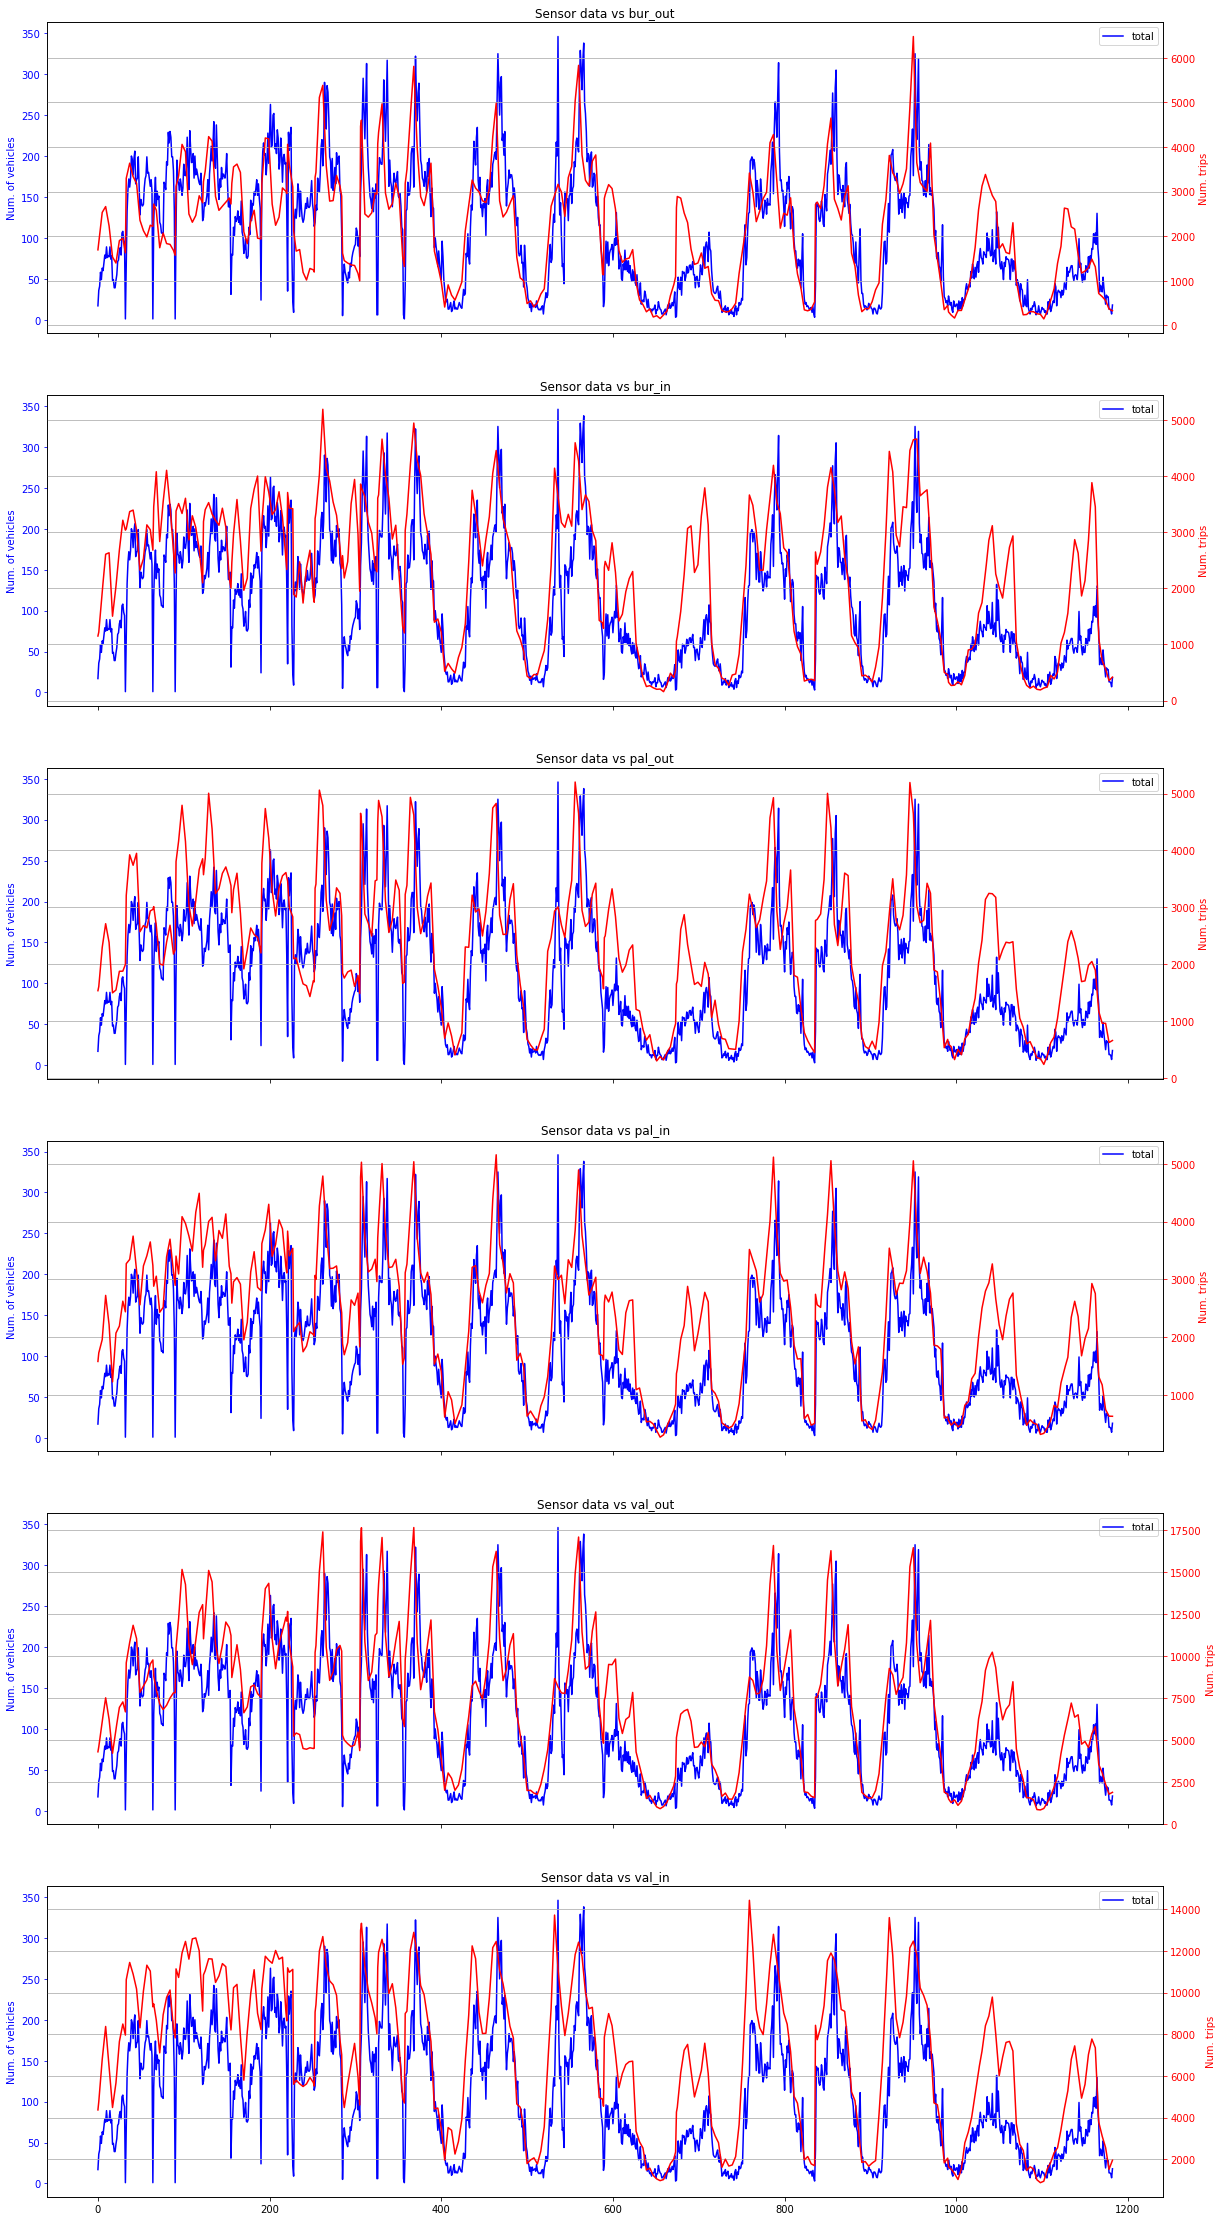

In [25]:
subflows_dict = dict(zip(['bur_out', 'bur_in', 'pal_out', 'pal_in', 'val_out', 'val_in'],
                    [bur_out_ts, bur_in_ts, pal_out_ts, pal_in_ts, val_out_ts, val_in_ts]))
plot_side_by_side_fn(r1_series, subflows_dict)

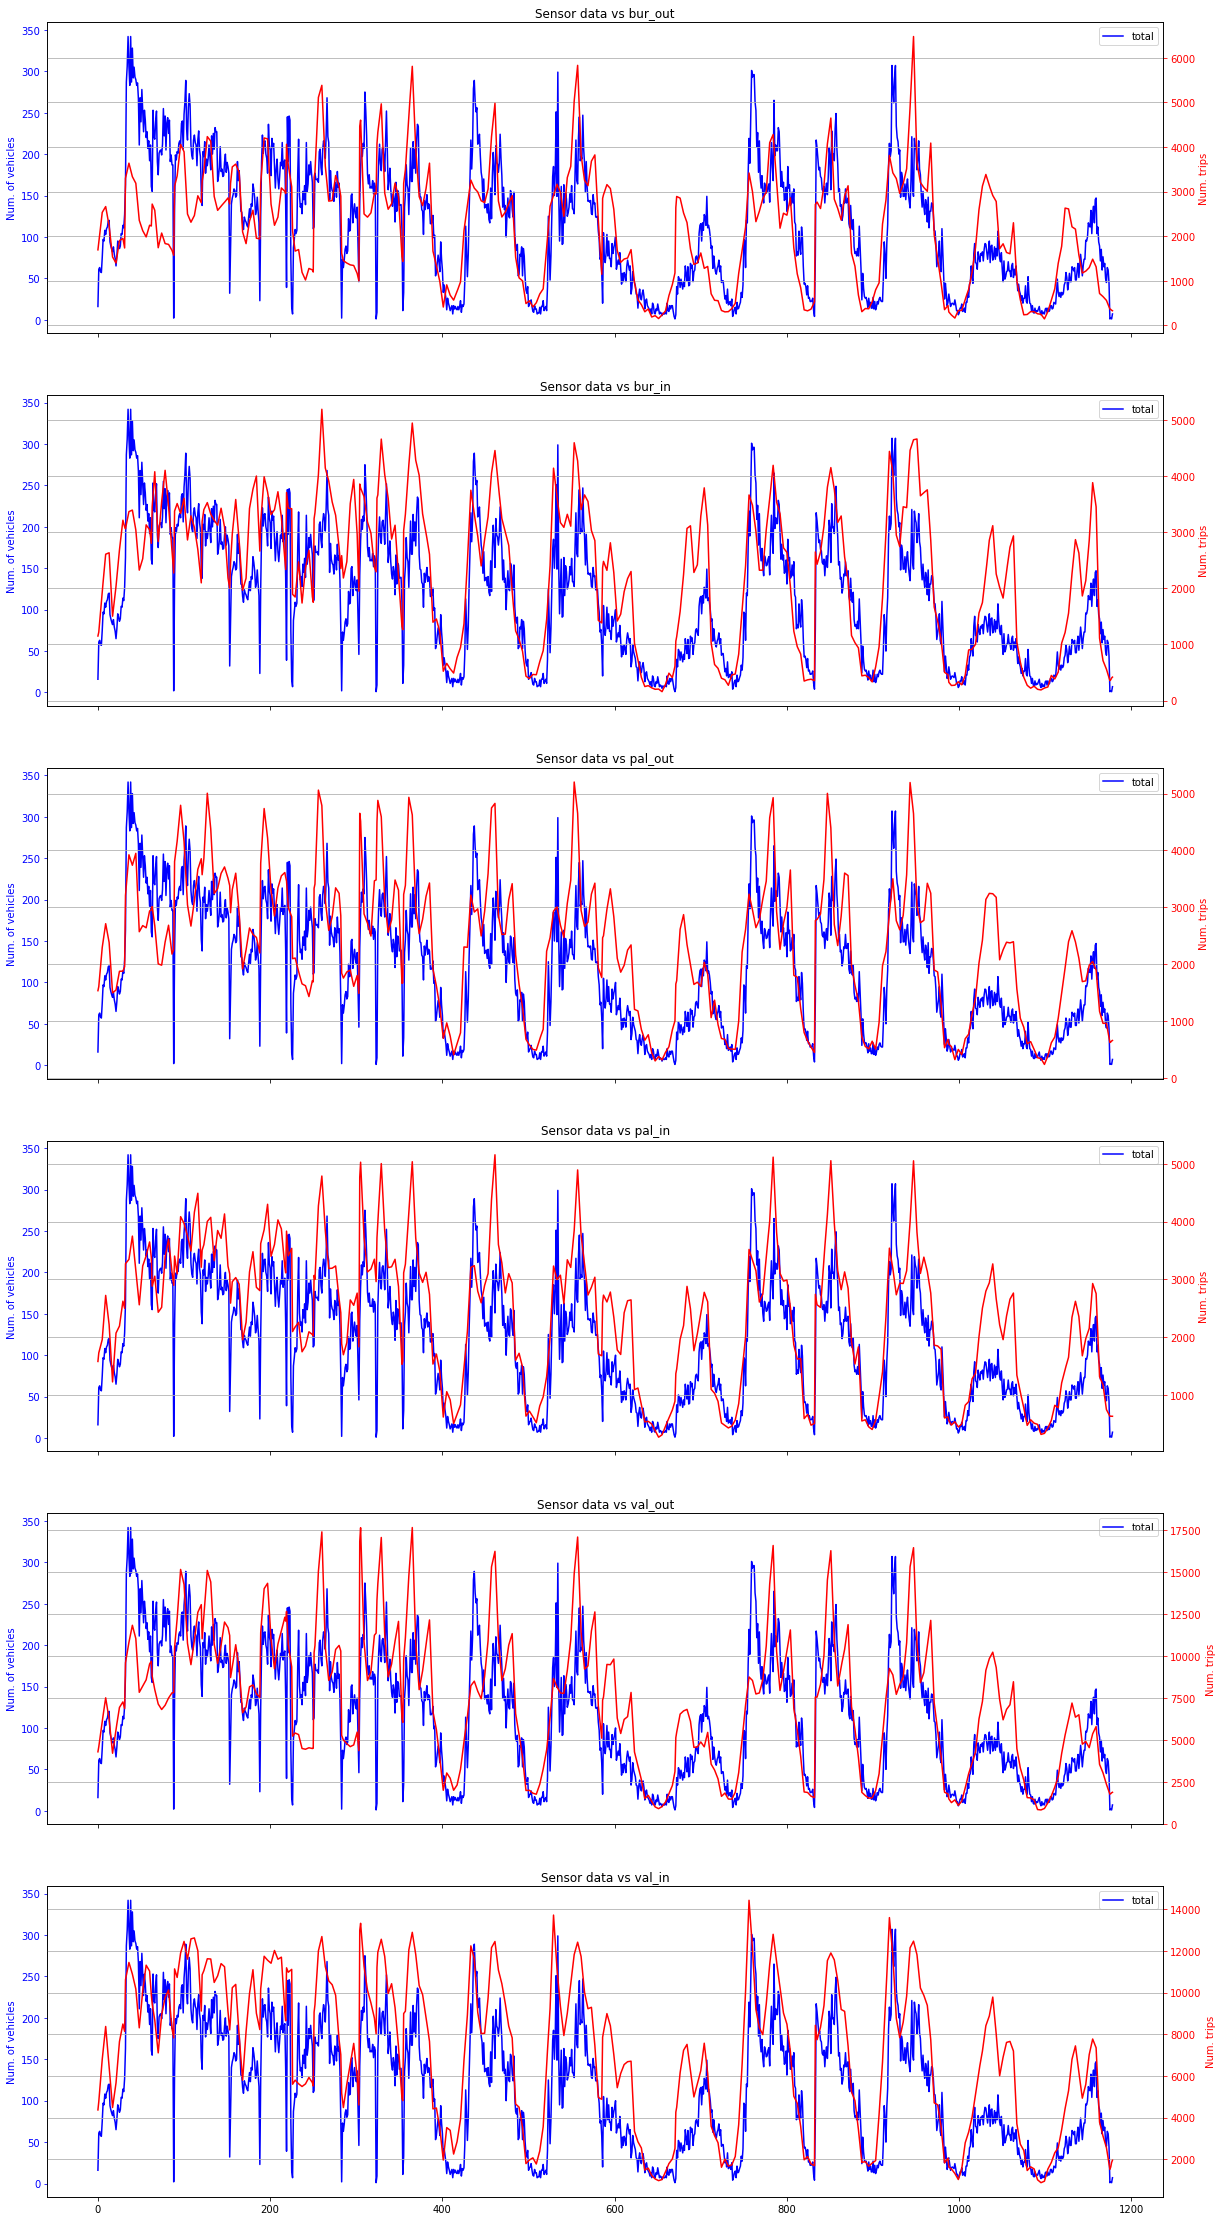

In [26]:
plot_side_by_side_fn(r2_series, subflows_dict)

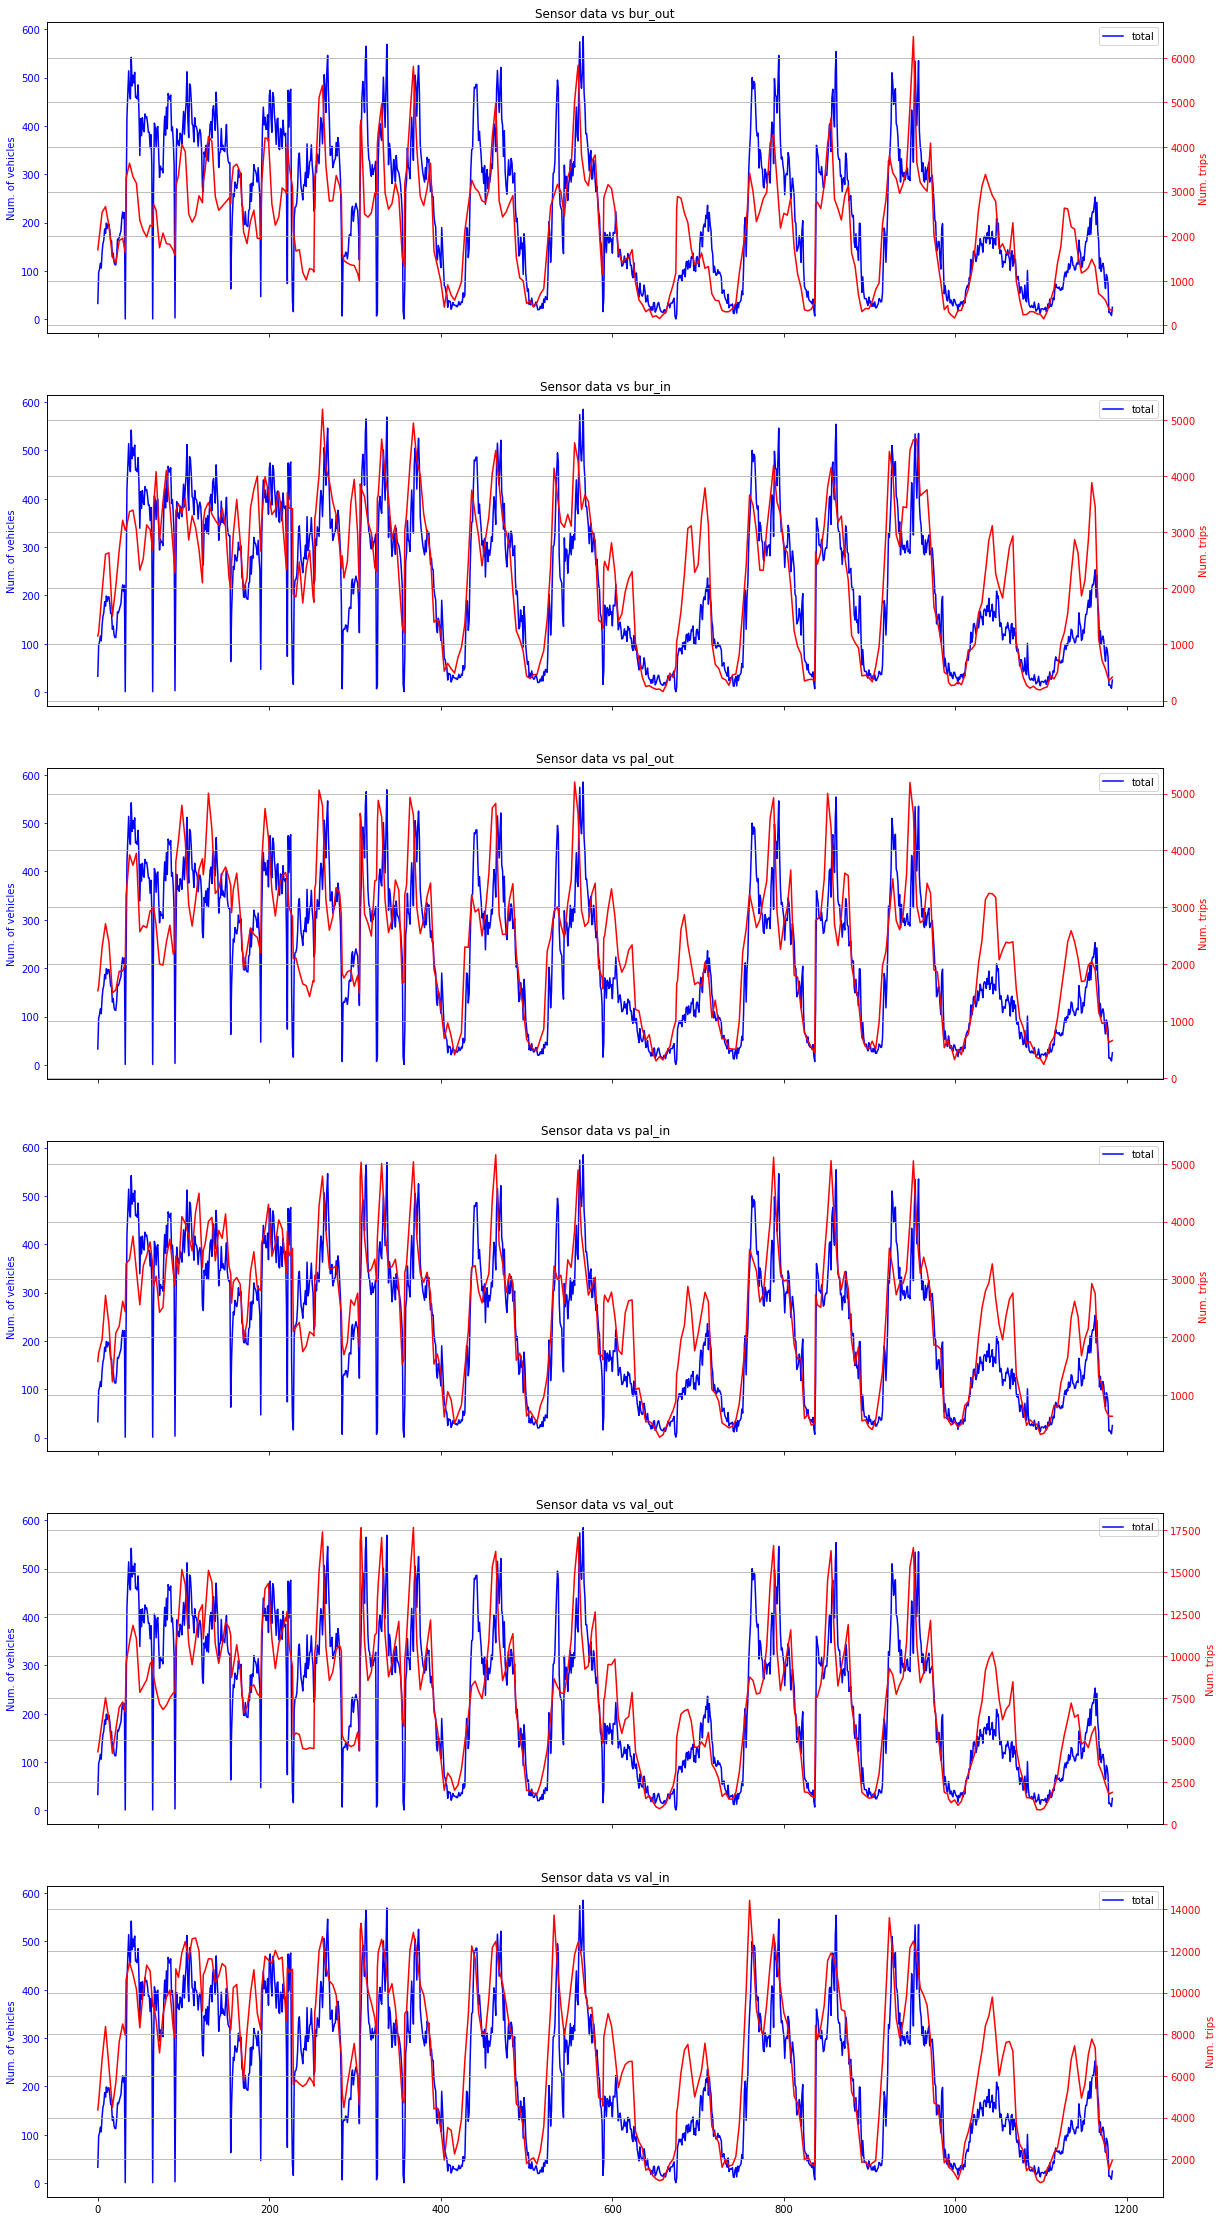

In [27]:
plot_side_by_side_fn(total_sensor, subflows_dict)

In [31]:
pairw_subflows_dict = dict(zip(['bur_pal', 'pal_bur', 'bur_val', 'val_bur', 'val_pal', 'pal_val'],
                    [bur_pal_ts, pal_bur_ts, bur_val_ts, val_bur_ts, val_pal_ts, pal_val_ts]))

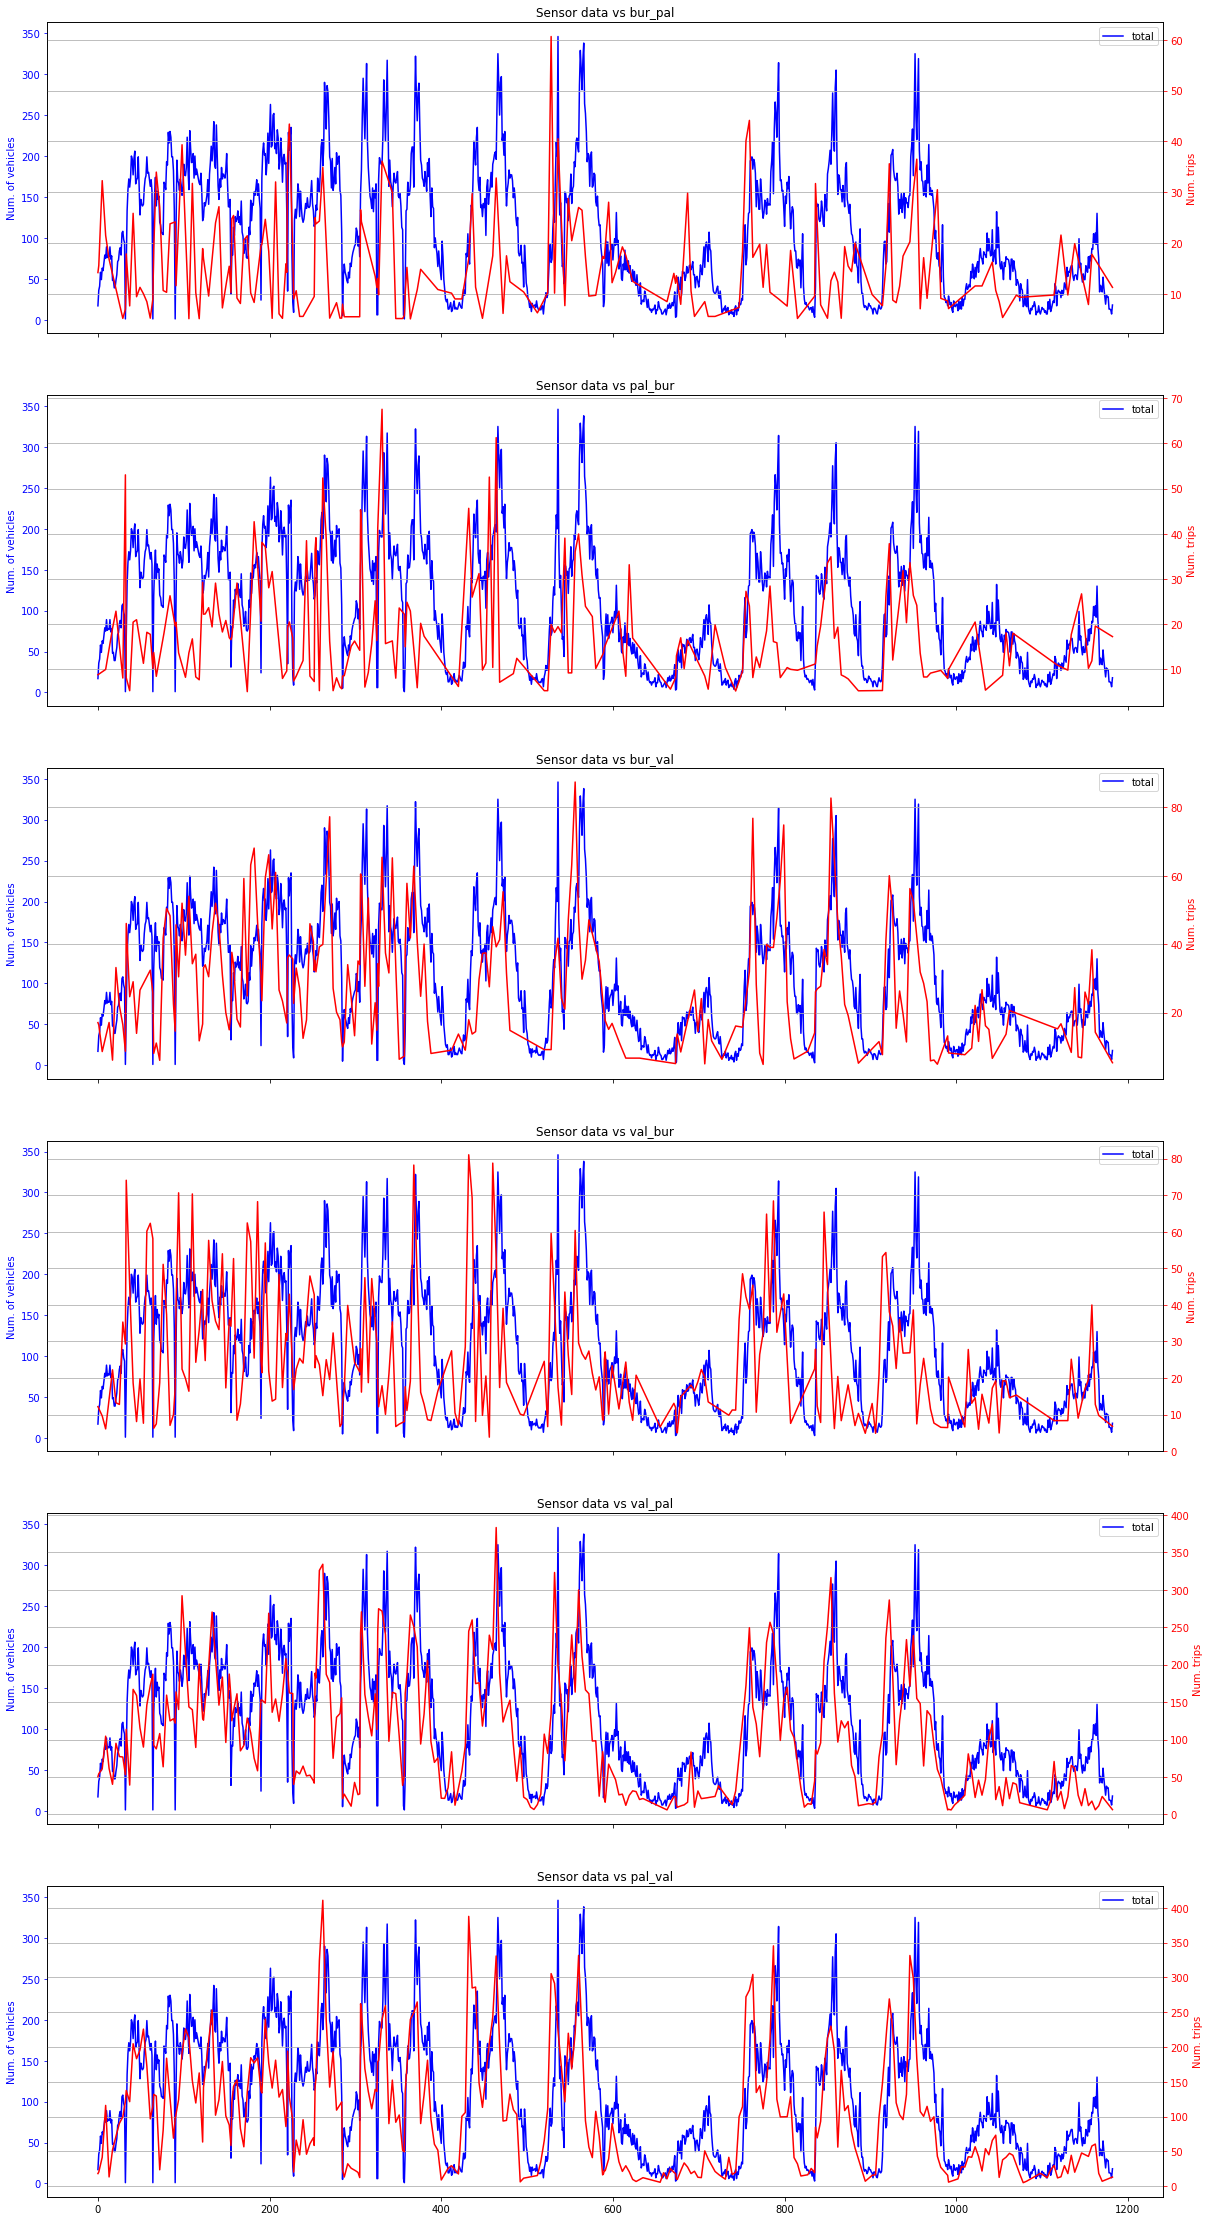

In [32]:
plot_side_by_side_fn(r1_series, pairw_subflows_dict)

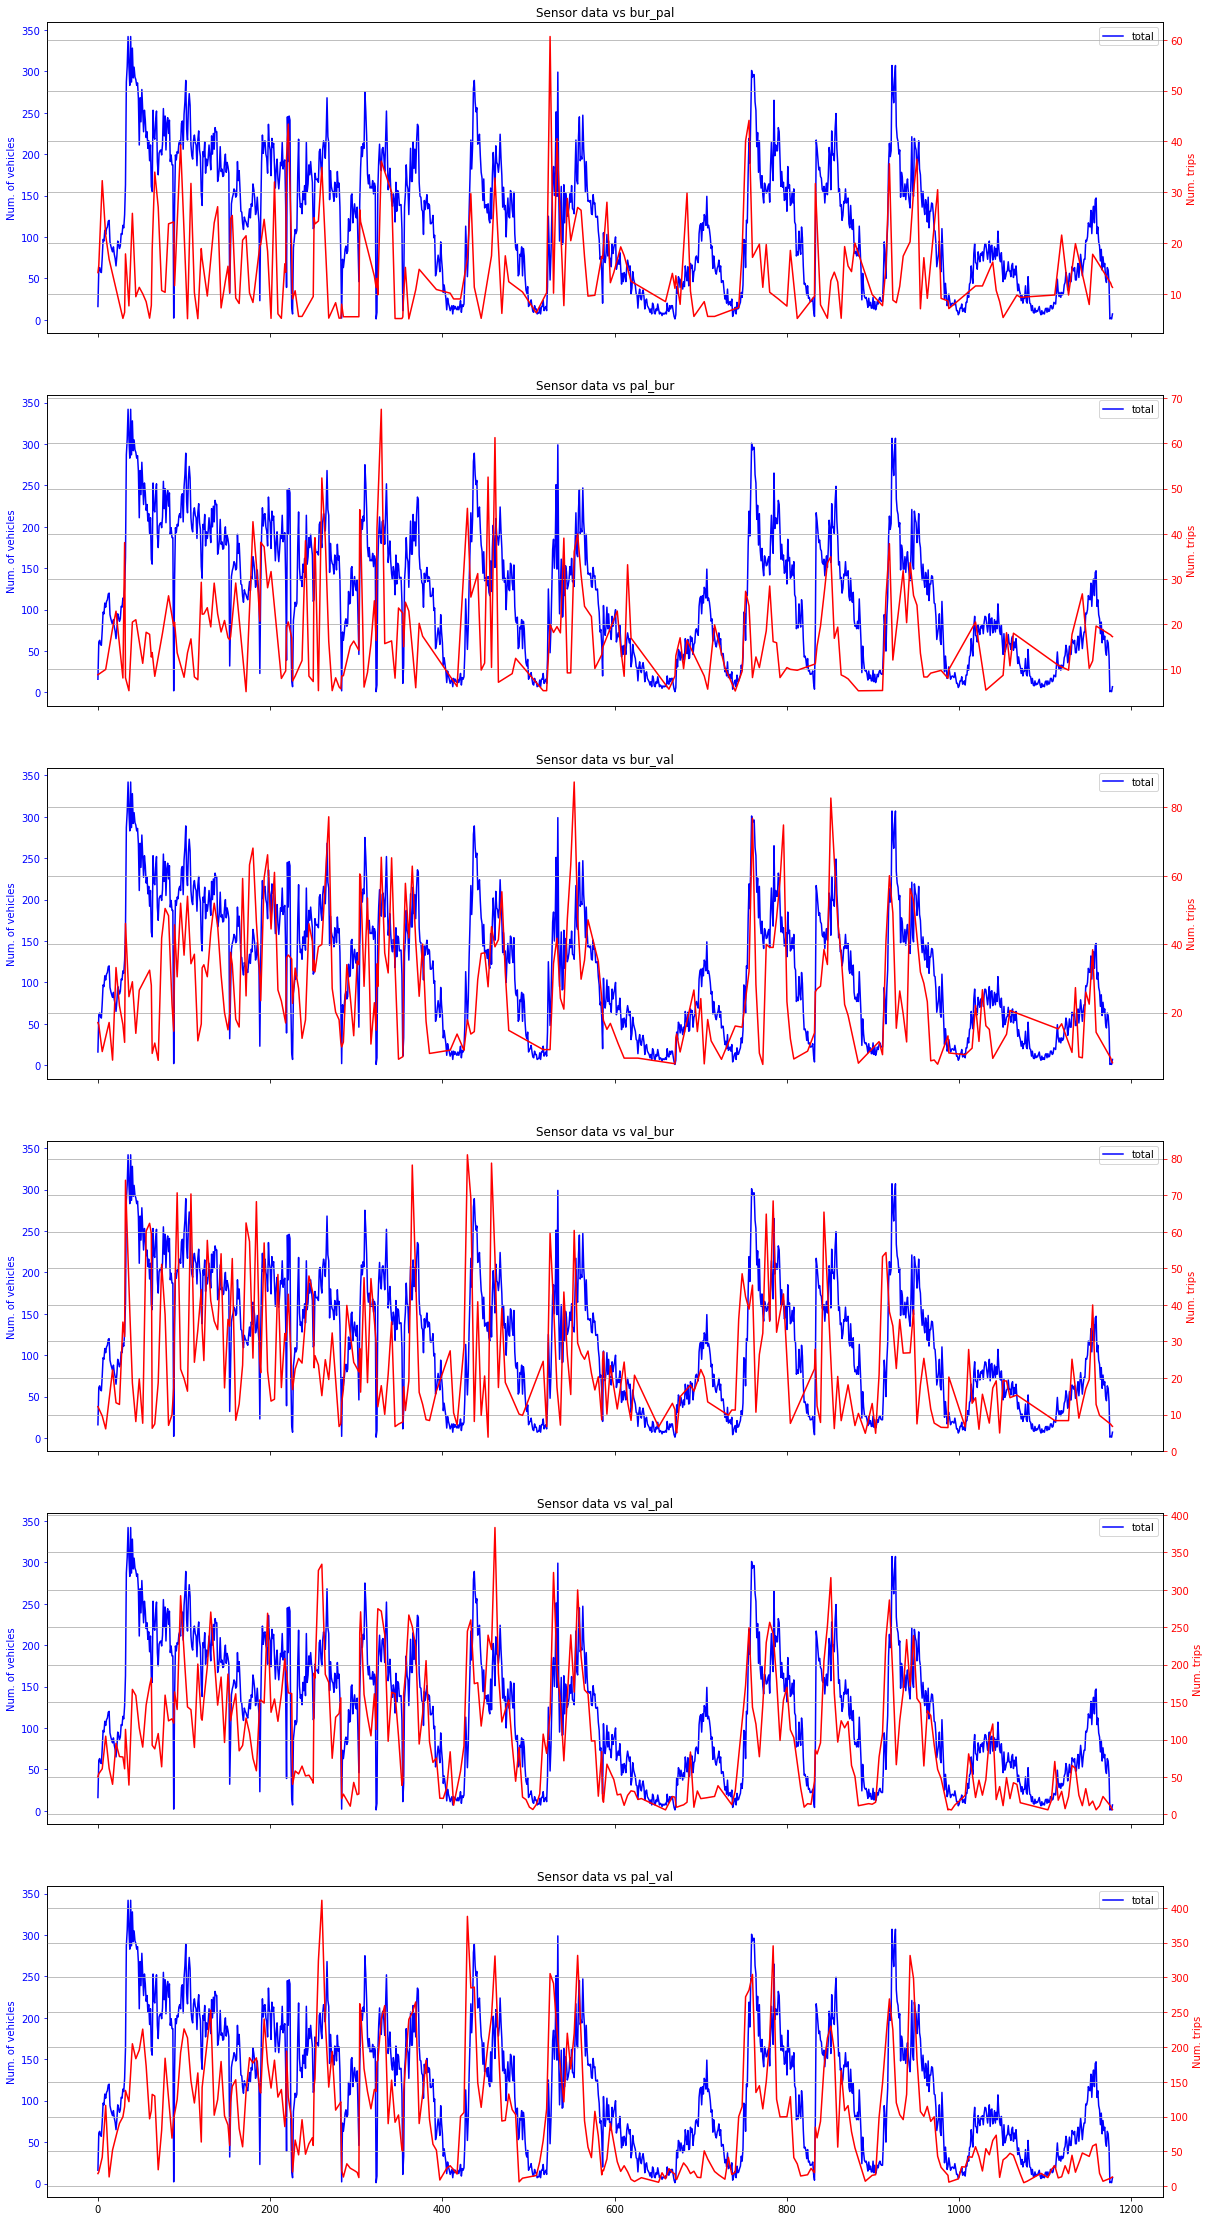

In [33]:
plot_side_by_side_fn(r2_series, pairw_subflows_dict)

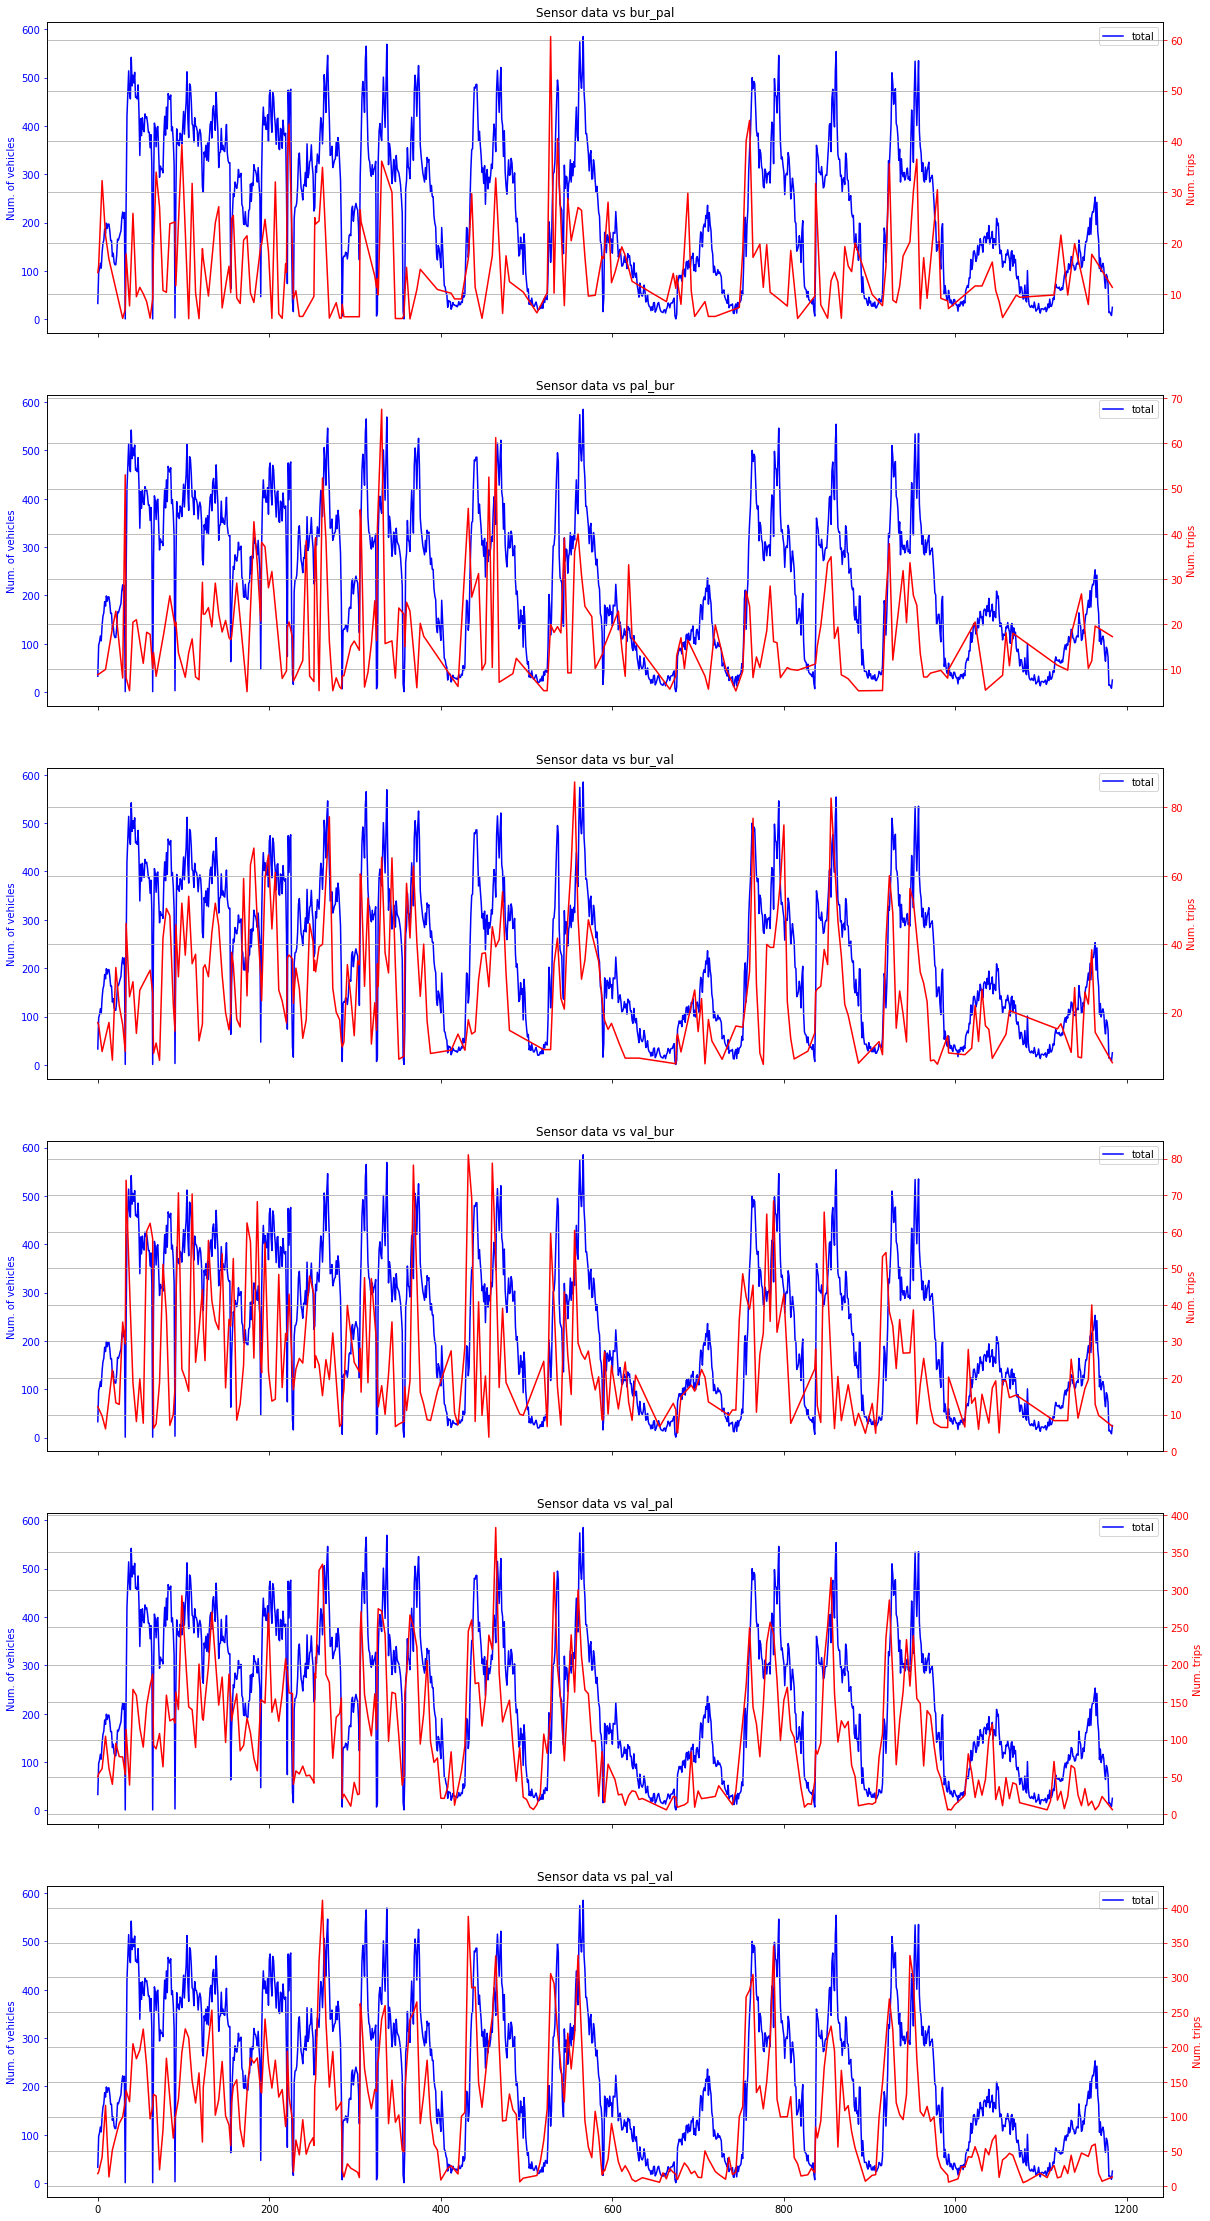

In [34]:
plot_side_by_side_fn(total_sensor, pairw_subflows_dict)

## Pearson Correlation

In [38]:
def calculate_correlations_fn(sensor_data, human_subflow):
    corr_={}
    target_days = sensor_data.index
    for c in human_subflow:
        # pearson
        r, p= stats.pearsonr(human_subflow[c].loc[target_days]['n_trips'], sensor_data['total'])
        
        # mutual info regression
        mi = mutual_info_regression(human_subflow[c].loc[target_days][['n_trips']].to_numpy(), 
                                    sensor_data['total'].to_numpy())
        
        # r2 score
        r2 = r2_score(human_subflow[c].loc[target_days]['n_trips'].to_numpy(), 
                      sensor_data.loc[target_days]['total'].to_numpy())
        
        corr_[c]= {'pearsonr': r, 'p-val': p, 'mutual_info_regression': mi[0], 'r2_score': r2}
    for c in corr_:
        print(f"Criterion {c}: \n\t Scipy computed Pearson r: {corr_[c]['pearsonr']} and p-value: {corr_[c]['p-val']} \n\t Sklearn mutual info regression: {corr_[c]['mutual_info_regression']} \n\t Sklearn r2 score: {corr_[c]['r2_score']} \n")
    return corr_

In [40]:
corr_r1= calculate_correlations_fn(r1_series, subflows_dict)

Criterion bur_out: 
	 Scipy computed Pearson r: 0.769537032429615 and p-value: 2.859874401804071e-232 
	 Sklearn mutual info regression: 0.6104790100861428 
	 Sklearn r2 score: -2.584817168955149 

Criterion bur_in: 
	 Scipy computed Pearson r: 0.8227039428844296 and p-value: 5.754217729826712e-292 
	 Sklearn mutual info regression: 0.7193472178499478 
	 Sklearn r2 score: -2.8808185970728912 

Criterion pal_out: 
	 Scipy computed Pearson r: 0.7757038101624139 and p-value: 2.4513777562015306e-238 
	 Sklearn mutual info regression: 0.7456492779335355 
	 Sklearn r2 score: -3.409299450080205 

Criterion pal_in: 
	 Scipy computed Pearson r: 0.8560199408714436 and p-value: 0.0 
	 Sklearn mutual info regression: 0.8967402336962245 
	 Sklearn r2 score: -3.5116866198216385 

Criterion val_out: 
	 Scipy computed Pearson r: 0.8119378190277782 and p-value: 2.3154772158482503e-278 
	 Sklearn mutual info regression: 0.8073252118913201 
	 Sklearn r2 score: -3.2783738107303853 

Criterion val_in: 
	 S

In [41]:
corr_r2= calculate_correlations_fn(r2_series, subflows_dict)

Criterion bur_out: 
	 Scipy computed Pearson r: 0.7051822774104886 and p-value: 5.587202100619853e-178 
	 Sklearn mutual info regression: 0.5920004167120125 
	 Sklearn r2 score: -2.5792008317332193 

Criterion bur_in: 
	 Scipy computed Pearson r: 0.7953638772605638 and p-value: 3.5277595495076475e-258 
	 Sklearn mutual info regression: 0.6407493316665525 
	 Sklearn r2 score: -2.8642028655950345 

Criterion pal_out: 
	 Scipy computed Pearson r: 0.7457092480946134 and p-value: 8.533066864420887e-210 
	 Sklearn mutual info regression: 0.6796701264530762 
	 Sklearn r2 score: -3.3893816549185916 

Criterion pal_in: 
	 Scipy computed Pearson r: 0.8205784062477353 and p-value: 3.0949403677408746e-288 
	 Sklearn mutual info regression: 0.7831301491557041 
	 Sklearn r2 score: -3.490555366686052 

Criterion val_out: 
	 Scipy computed Pearson r: 0.7451916458037938 and p-value: 2.3731048933540114e-209 
	 Sklearn mutual info regression: 0.7167279520253871 
	 Sklearn r2 score: -3.271058286799616 

C

In [42]:
corr_rotal= calculate_correlations_fn(total_sensor, subflows_dict)

Criterion bur_out: 
	 Scipy computed Pearson r: 0.7600703269121162 and p-value: 1.6683309761531749e-223 
	 Sklearn mutual info regression: 0.6075444875863982 
	 Sklearn r2 score: -2.2152064647344822 

Criterion bur_in: 
	 Scipy computed Pearson r: 0.8331424000719845 and p-value: 2.5124418904760783e-306 
	 Sklearn mutual info regression: 0.7720786643691393 
	 Sklearn r2 score: -2.48354801778381 

Criterion pal_out: 
	 Scipy computed Pearson r: 0.7836472285225342 and p-value: 1.1906978668984886e-246 
	 Sklearn mutual info regression: 0.7950365993351096 
	 Sklearn r2 score: -2.963785696940933 

Criterion pal_in: 
	 Scipy computed Pearson r: 0.8630419274087122 and p-value: 0.0 
	 Sklearn mutual info regression: 0.9014866172784144 
	 Sklearn r2 score: -3.052705974112577 

Criterion val_out: 
	 Scipy computed Pearson r: 0.8016282374598076 and p-value: 2.3446427469249777e-266 
	 Sklearn mutual info regression: 0.8090962648869944 
	 Sklearn r2 score: -3.1413186636380193 

Criterion val_in: 
	 

### Correlations of pairwise flows

In [43]:
corr_r1= calculate_correlations_fn(r1_series, pairw_subflows_dict)

Criterion bur_pal: 
	 Scipy computed Pearson r: 0.34894553521650207 and p-value: 3.3349339188102557e-35 
	 Sklearn mutual info regression: 0.1404408220251483 
	 Sklearn r2 score: -249.03723851385416 

Criterion pal_bur: 
	 Scipy computed Pearson r: 0.3833740566428948 and p-value: 1.0297068141826999e-42 
	 Sklearn mutual info regression: 0.18073922938349885 
	 Sklearn r2 score: -173.00496198570607 

Criterion bur_val: 
	 Scipy computed Pearson r: 0.6893690046670349 and p-value: 1.47483885220929e-167 
	 Sklearn mutual info regression: 0.43552896638437 
	 Sklearn r2 score: -41.451761153989025 

Criterion val_bur: 
	 Scipy computed Pearson r: 0.38489701488250394 and p-value: 4.560479640751944e-43 
	 Sklearn mutual info regression: 0.13886870863439738 
	 Sklearn r2 score: -58.02259034870577 

Criterion val_pal: 
	 Scipy computed Pearson r: 0.7502357335573241 and p-value: 1.9071994181053564e-214 
	 Sklearn mutual info regression: 0.5596054965457666 
	 Sklearn r2 score: 0.498999562213994 

Cr

In [44]:
corr_r2= calculate_correlations_fn(r2_series, pairw_subflows_dict)

Criterion bur_pal: 
	 Scipy computed Pearson r: 0.31658988021577017 and p-value: 7.4020177786845e-29 
	 Sklearn mutual info regression: 0.2176650525175181 
	 Sklearn r2 score: -273.65160816054197 

Criterion pal_bur: 
	 Scipy computed Pearson r: 0.3408320672376569 and p-value: 1.8628408865429793e-33 
	 Sklearn mutual info regression: 0.24158559889010167 
	 Sklearn r2 score: -193.21626867570671 

Criterion bur_val: 
	 Scipy computed Pearson r: 0.6313201315564209 and p-value: 4.151054728357716e-132 
	 Sklearn mutual info regression: 0.42929940279506074 
	 Sklearn r2 score: -46.52318996584902 

Criterion val_bur: 
	 Scipy computed Pearson r: 0.42394945322853367 and p-value: 1.259202915579231e-52 
	 Sklearn mutual info regression: 0.14439590217208975 
	 Sklearn r2 score: -63.9361404967044 

Criterion val_pal: 
	 Scipy computed Pearson r: 0.6848851640951596 and p-value: 5.199597128470196e-164 
	 Sklearn mutual info regression: 0.504586935130579 
	 Sklearn r2 score: 0.3370689794661349 

Crit

In [45]:
corr_rotal= calculate_correlations_fn(total_sensor, pairw_subflows_dict)

Criterion bur_pal: 
	 Scipy computed Pearson r: 0.3438309101765153 and p-value: 3.423682780566663e-34 
	 Sklearn mutual info regression: 0.23903248345288297 
	 Sklearn r2 score: -1132.0710399385111 

Criterion pal_bur: 
	 Scipy computed Pearson r: 0.3686803400434169 and p-value: 1.988070808679369e-39 
	 Sklearn mutual info regression: 0.24293425987276862 
	 Sklearn r2 score: -801.8286748622357 

Criterion bur_val: 
	 Scipy computed Pearson r: 0.6810031638758457 and p-value: 3.808175777121418e-162 
	 Sklearn mutual info regression: 0.4419316303126344 
	 Sklearn r2 score: -216.18957473406695 

Criterion val_bur: 
	 Scipy computed Pearson r: 0.41566014330913836 and p-value: 1.1511991363323467e-50 
	 Sklearn mutual info regression: 0.15813870140894037 
	 Sklearn r2 score: -285.281985364593 

Criterion val_pal: 
	 Scipy computed Pearson r: 0.7385894441318802 and p-value: 1.2338015676991564e-204 
	 Sklearn mutual info regression: 0.5585941475528275 
	 Sklearn r2 score: -3.3611923305373486 



### Explore flows

In [2]:
bur_in_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'bur_in.csv'))
bur_out_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'bur_out.csv'))

pal_in_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'pal_in.csv'))
pal_out_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'pal_out.csv'))

val_in_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'val_in.csv'))
val_out_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'val_out.csv'))

In [4]:
bur_in_ts.head()

fecha_periodo     n_trips
0  2021-01-01 00:00:00  1481.36700
1  2021-01-01 00:15:00  1435.42225
2  2021-01-01 00:30:00  1389.47750
3  2021-01-01 00:45:00  1343.53275
4  2021-01-01 01:00:00  1297.58800

In [9]:
val_out_ts.describe()

n_trips
count   3069.000000
mean    6265.623051
std     3974.003388
min      742.357000
25%     2360.738000
50%     6096.323500
75%     9048.696000
max    18076.357000

In [10]:
bur_pal_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'bur_pal.csv'))
pal_bur_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'pal_bur.csv'))

bur_val_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'bur_val.csv'))
val_bur_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'val_bur.csv'))

val_pal_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'val_pal.csv'))
pal_val_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'pal_val.csv'))

In [16]:
pal_val_ts.describe()

n_trips
count  3065.000000
mean     91.870509
std      83.147586
min       4.853000
25%      19.397375
50%      65.661000
75%     140.363500
max     410.753000